<div style="background:#2b6684">
</div>
           

Source - Spotify: "In Spotify's API is something called Valence, that describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (happy, cheerful, euphoric), while tracks with low valence sound more negative (sad, depressed, angry)."

From very good article explaining Spotify API What Makes a Song Likeable?- https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404 we can read that:

Spotify Audio Features
For every track on their platform, Spotify provides data for thirteen Audio Features.The Spotify Web API developer guide defines them as follows:

**Danceability:** Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

**Valence:** Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

**Energy:** Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

**Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.

**Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

**Speechiness:** This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

**Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.

**Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

**Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

**Key:** The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.


**Duration:** The duration of the track in milliseconds.

**Time Signature:** An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

<div style 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb

### Load Dataset

In [2]:
df_train = pd.read_csv('../input/song-popularity-prediction/train.csv')
df_test = pd.read_csv('../input/song-popularity-prediction/test.csv')
df_train.shape, df_test.shape

((40000, 15), (10000, 14))

In [3]:
df_train.head(5)

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [5]:
df_train.isnull().sum()

id                     0
song_duration_ms    4101
acousticness        3992
danceability        4026
energy              3975
instrumentalness    3985
key                 4065
liveness            4086
loudness            3957
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64

### Predictor features

In [6]:
FEATURES = ['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'audio_mode',
 'speechiness',
 'tempo',
 'time_signature',
 'audio_valence']

categorical_cols = ['key', 'audio_mode', 'time_signature']

numerical_cols = [col for col in FEATURES if col not in categorical_cols]
numerical_cols

['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'audio_valence']

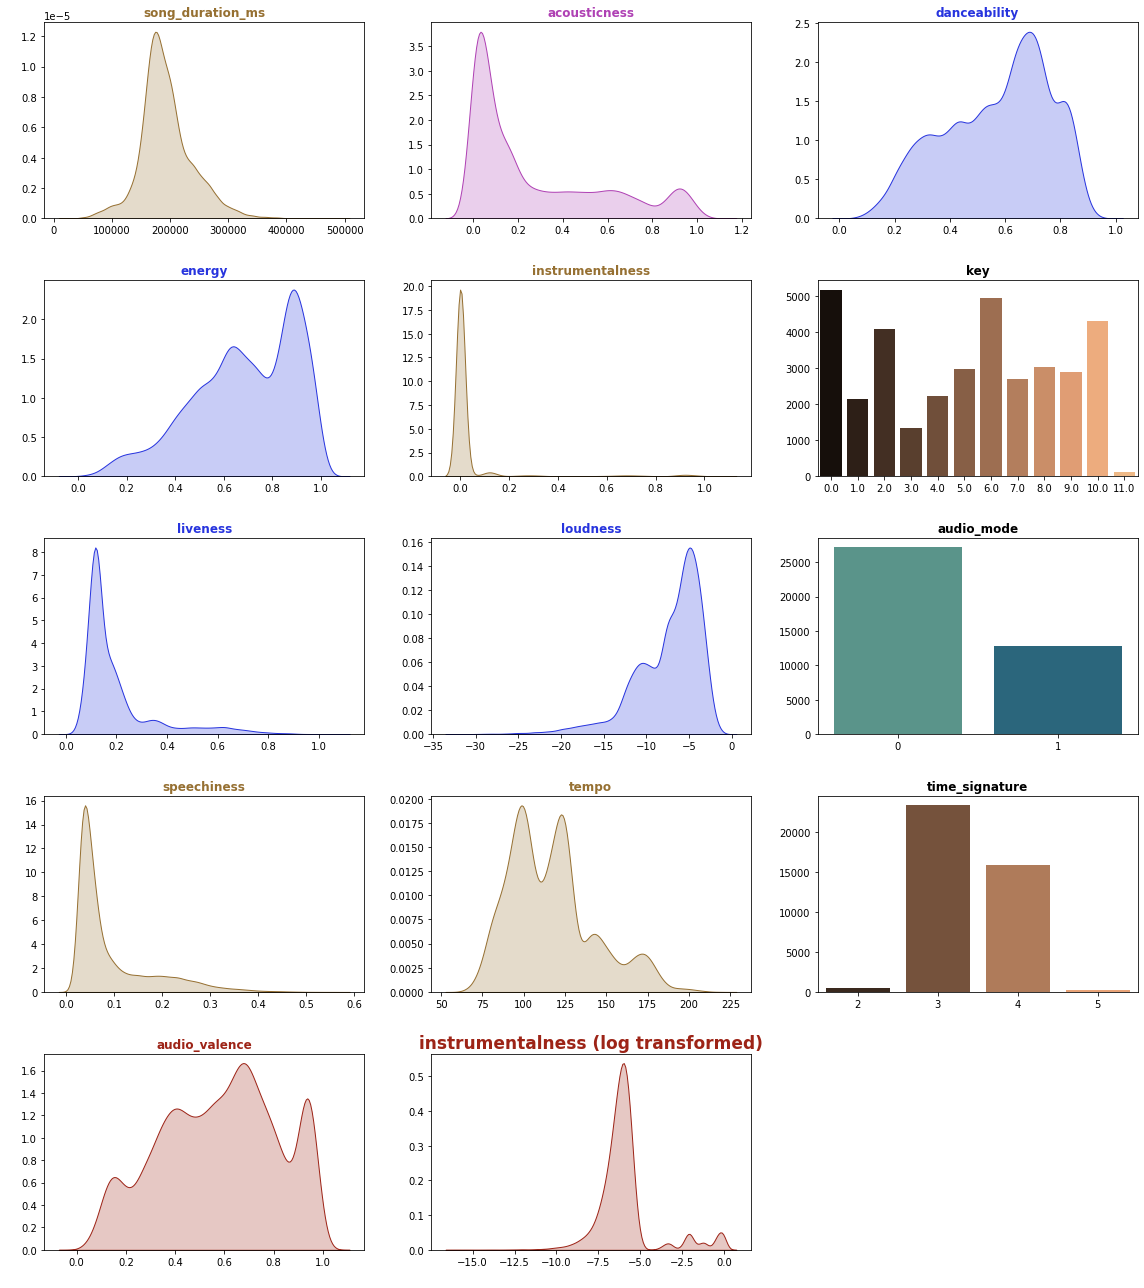

In [7]:
import random
import matplotlib.pyplot as plt

color_ = [ '#9D2417', '#AF41B4', '#003389' ,'#3C5F41',  '#967032', '#2734DE'] 
cmap_ = ['magma', 'copper', 'crest']

plt.figure(figsize= (16,18))
for i,col in enumerate(df_train[FEATURES].columns):
    rand_col = color_[random.sample(range(6), 1)[0]]
    plt.subplot(5,3, i+1)
    if col in numerical_cols:
        
        sns.kdeplot(df_train[col], color = rand_col, fill = rand_col )
        plt.title(col,weight = 'bold', color = rand_col)
        plt.ylabel(" ")
        plt.xlabel(" ")
        plt.tight_layout()
    else:
        sns.countplot(data = df_train , x = col, palette = cmap_[random.sample(range(3), 1)[0]] )
        plt.title(col,weight = 'bold', color = 'black')
        plt.ylabel(" ")
        plt.xlabel(" ")
        plt.tight_layout()
        
plt.subplot(5,3, 14)
sns.kdeplot(np.log(df_train['instrumentalness']), color = rand_col, fill = rand_col )
plt.title('instrumentalness (log transformed)',weight = 'bold', color = rand_col, size = 17)
plt.ylabel(" ")
plt.xlabel(" ")
plt.tight_layout()
plt.show();

- audio_mode is a boolean features, time_signature and key are categorical or ordinal features. 
- values of accosticness, danceability, energy, liveliness, speechiness, and audio_valence features are in between 0 and 1
- The feature loudness looks like it refer to the decibel scale
- The distribution of instrumentalness is heavily right-skewed, and even after a log transform this feature doesn’t look very well-behaved. This might need a bit more work.

Text(0.5, 1.0, 'Target: Song Popularity')

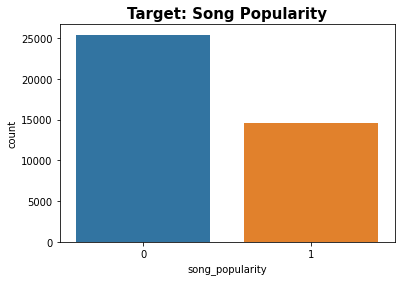

In [8]:
plt.figure(figsize = (6,4))
ax = sns.countplot(x='song_popularity', data = df_train)
plt.title("Target: Song Popularity",weight = 'bold', color = 'black', size = 15)

There is a slight imbalance in the target distribution: a bit more than 60/40. Not super imbalanced, but something to keep in mind.

After learning more about each individual feature, we now want to see them interacting with one another. It’s best to perfom those steps in that order, so that you can understand and interpret the interactions in the context of the overall distributions.

**Target impact**
- We have seen all the feature distributions, now we want to investigate whether they look different based on the target value. Here’s an example for song_duration:

**Feature-Feature interaction (correlation)**
- How do the predictor features interact with each other? Are there any redundancies or strong relationships? We will start out with a correlation matrix, and then look at features of interest in a bit more detail.

**Feature-target interactions**
- Once we have found interesting correlations we can look for clustering in the target variable.

**Target impact**
- We have seen all the feature distributions, now we want to investigate whether they look different based on the target value. So, let's plot all of them together and understand the pattern.

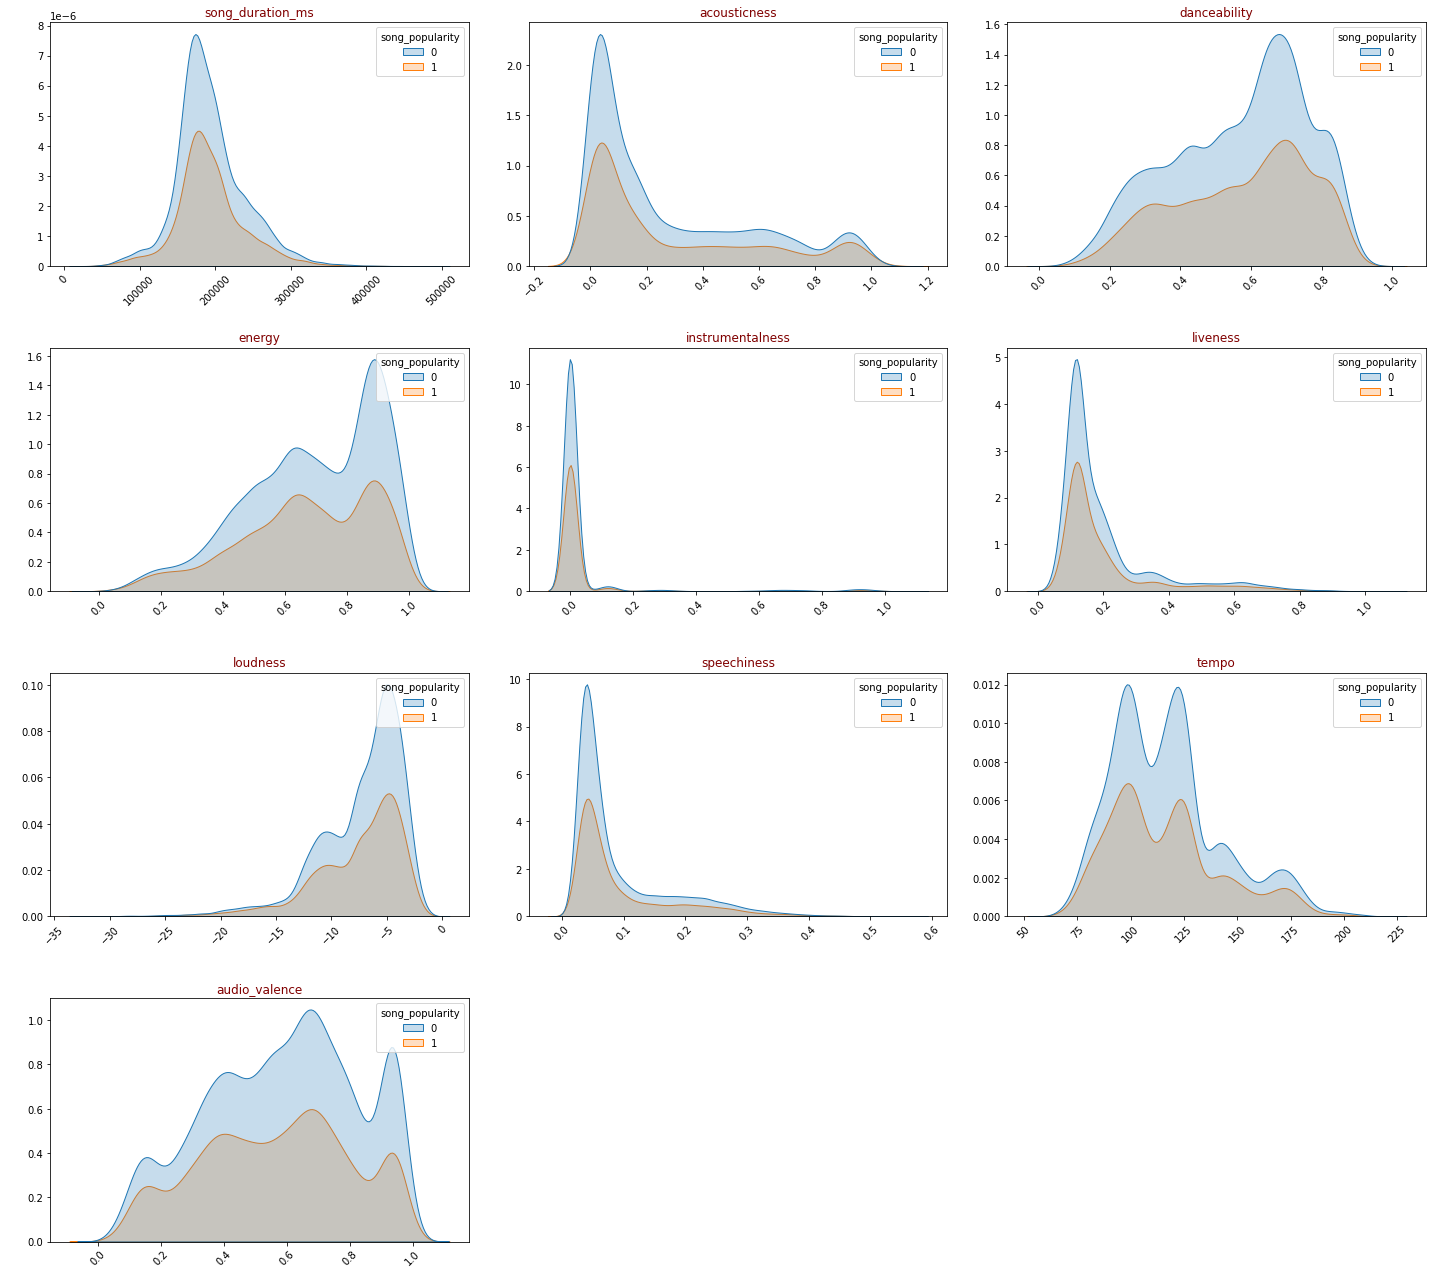

In [9]:
plt.figure(figsize = (20,18))
color_ = [ '#9D2417', '#AF41B4', '#003389' ,'#3C5F41',  '#967032', '#2734DE'] 
for i in enumerate(df_train[numerical_cols].columns):
  rand_col = color_[random.sample(range(6), 1)[0]]

  plt.subplot(4,3,i[0]+1)
  sns.kdeplot(data = df_train, x = i[1], hue = 'song_popularity', fill = rand_col, color = rand_col )
  plt.title (i[1], color = 'maroon')
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.xticks(rotation = 45)
  plt.tight_layout()

**Observations:**

By looking at the probability distribution of different variables we find that popular songs are almost exactly the same length as unpopular ones. There is a slight difference, but it’s pretty small.

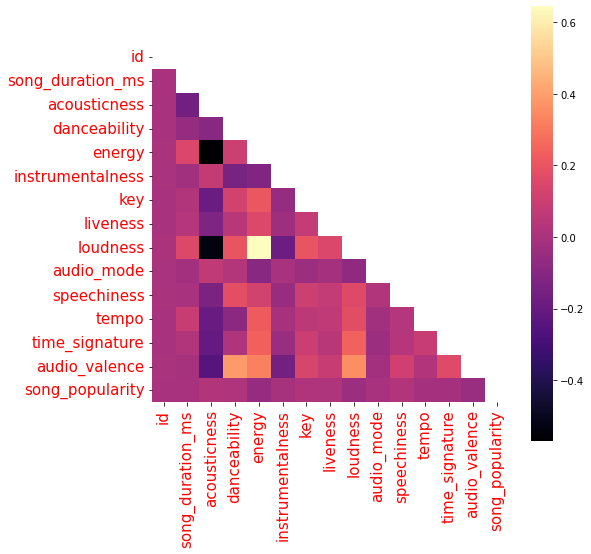

In [10]:
plt.figure(figsize = (8,8))
corr_matrix = df_train.corr()
 
matrix = np.triu(corr_matrix) # take lower correlation matrix

# Draw the heatmap with the mask
sns.heatmap(corr_matrix.T, mask=matrix, square=True, cmap = 'magma')
plt.xticks(size = 15,color = 'red')
plt.yticks(size = 15,  color = 'red');

- There’s a strong anti-correlation between acousticness vs energy and loudness, respectively. Consequently, energy and loudness share a strong correlation.
- None of the features individually show a notable correlation with the target song_popularity.
- Let’s plot energy vs acousticness to get a feel for this correlation.

### Feature-Feature interaction (correlation)
How do the predictor features interact with each other? Are there any redundancies or strong relationships? We will start out with a correlation matrix, and then look at features of interest in a bit more detail.

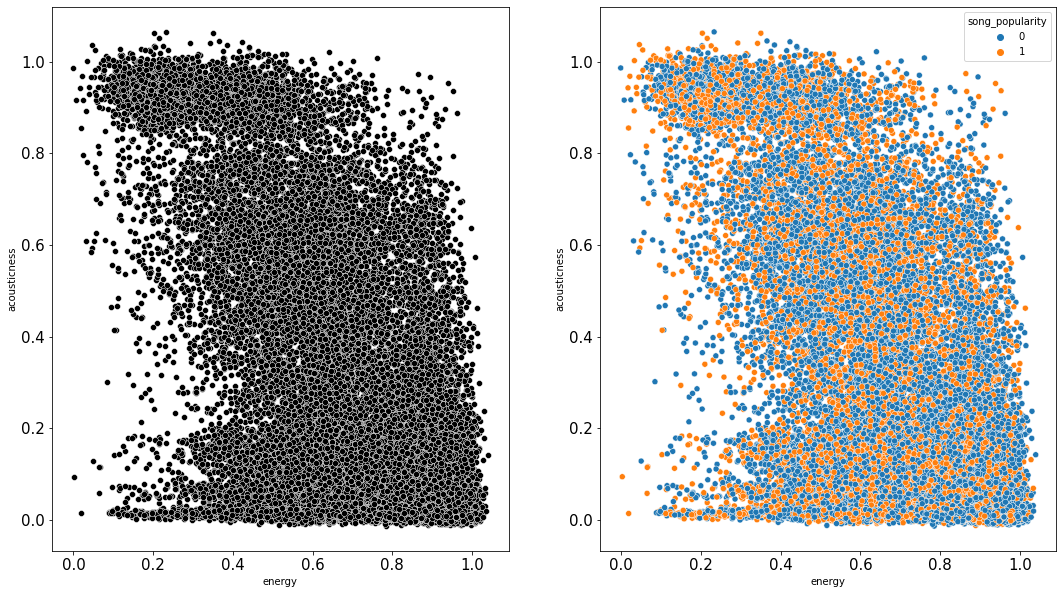

In [11]:
plt.figure(figsize = (18,10))

plt.subplot(1,2,1)
sns.scatterplot(data = df_train, x = 'energy', y = 'acousticness', color = 'black')
plt.xticks(size = 15,)
plt.yticks(size = 15,)

plt.subplot(1,2,2)
sns.scatterplot(data = df_train, x = 'energy', y = 'acousticness', hue = 'song_popularity')
plt.xticks(size = 15,)
plt.yticks(size = 15,);

Let's plot a pairplot to check the cluster pattern between two independent variables with respect to song_popularity.

In [12]:
'''df_train.song_popularity = df_train.song_popularity.astype('object')
plt.figure(figsize = (20,20))
sns.pairplot(data = df_train, hue = 'song_popularity',vars=numerical_cols)'''

"df_train.song_popularity = df_train.song_popularity.astype('object')\nplt.figure(figsize = (20,20))\nsns.pairplot(data = df_train, hue = 'song_popularity',vars=numerical_cols)"

- Data is not linearly separable.
- There are some clusters visible between instrumentalness and some other variables, it'll be interesting to see what can be infered from them after further investigation.

### Missing values
Let's combine the test and train data to see the distribution of missing values in the whole dateset. 

In [13]:
#combine train and test data together to deal with missing values
df_train['isTrain'] = True
df_test['isTrain'] = False
tt = pd.concat([df_train, df_test]).reset_index(drop=True).copy()
df_train.shape, df_test.shape, tt.shape

((40000, 16), (10000, 15), (50000, 16))

In [14]:
tt.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,isTrain
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0.0,True
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1.0,True
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0.0,True
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0.0,True
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0.0,True


In [15]:
list(tt.columns)

['id',
 'song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'audio_mode',
 'speechiness',
 'tempo',
 'time_signature',
 'audio_valence',
 'song_popularity',
 'isTrain']

Before we start, we should ask why there is missing values in the data. 
examples could be,
1. Sensor data where the sensor went offline
2. Survey data where some answeres were not answered
3. A kaggle competition where the host wants to make the problem hard
Sometimes values being null itself is a indicator to help out with the modeling technique. It could be the values are radomly missing or the fact that they missing could be a feature itself. 

Let's see the missing value counts in train vs. test

In [16]:
df_train.isna()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,isTrain
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
39996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
39997,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
39998,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False


In [17]:
df_test.isna()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,isTrain
0,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
df_train.isna().sum()

id                     0
song_duration_ms    4101
acousticness        3992
danceability        4026
energy              3975
instrumentalness    3985
key                 4065
liveness            4086
loudness            3957
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
isTrain                0
dtype: int64

In [19]:
df_test.isna().sum()

id                     0
song_duration_ms     957
acousticness         950
danceability         976
energy              1055
instrumentalness    1000
key                  992
liveness            1006
loudness            1026
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
isTrain                0
dtype: int64

We see in both train and test data, there are some features with missing values and some without. 

Now we want to see is there any diffirenct between the null values in the trian and test data in the dataset

In [20]:
#creating a dataframe with null values in the test and train dataset
ncounts = pd.DataFrame([df_train.isna().mean(), df_test.isna().mean()]).T
ncounts = ncounts.rename(columns={0: 'train_missing', 1: 'test_missing'})
ncounts

,train_missing,test_missing
id,0.000000,0.0000
song_duration_ms,0.102525,0.0957
acousticness,0.099800,0.0950
danceability,0.100650,0.0976
energy,0.099375,0.1055
instrumentalness,0.099625,0.1000
key,0.101625,0.0992
liveness,0.102150,0.1006
loudness,0.098925,0.1026
audio_mode,0.000000,0.0000


<AxesSubplot:title={'center':'%of missing values'}>

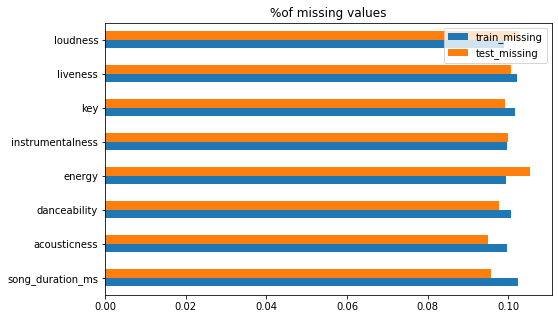

In [21]:
# filter out the non-missing features and 
# plot the features with missing vlaues only
ncounts.query('train_missing > 0').plot(kind='barh',
                                        figsize=(8,5), 
                                        title='%of missing values')

This is very interesting that all the features in both in trian and test data, approximately 10% of the data is missing. This is worth more exploration and thinking



In [22]:
#columns with null values
nacols = ['song_duration_ms',
         'acousticness',
         'danceability',
         'energy',
         'instrumentalness',
         'key',
         'liveness',
         'loudness']

### Missing values per observations/example

In [23]:
# counts of null per row/example
df_train.isna().sum(axis=1)

0        1
1        1
2        1
3        0
4        1
        ..
39995    1
39996    0
39997    1
39998    2
39999    0
Length: 40000, dtype: int64

In [24]:
tt['n_missing'] = tt[nacols].isna().sum(axis=1)
df_train['n_missing'] = df_train[nacols].isna().sum(axis=1)
df_test['n_missing'] = df_test[nacols].isna().sum(axis=1)

In [25]:
tt['n_missing']

0        1
1        1
2        1
3        0
4        1
        ..
49995    0
49996    0
49997    0
49998    0
49999    1
Name: n_missing, Length: 50000, dtype: int64

In [26]:
# how many of the samples has 0 misisng values, 1 missing values and so on
tt['n_missing'].value_counts()

0    21668
1    18880
2     7421
3     1738
4      255
5       35
6        3
Name: n_missing, dtype: int64

we see that most of our samples has no missing values, 18880 samples has 1 missing values, 7421 samples has 2 missing values and so on. This make sence since only 10% of the data is missing in this dataset

<AxesSubplot:title={'center':'Number of Missing Valeus per Sample'}>

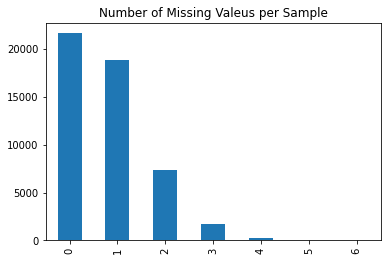

In [27]:
tt['n_missing'].value_counts().plot(kind='bar',
                                   title='Number of Missing Valeus per Sample')

In [28]:
tt.query('n_missing == 6') # samples with 6 missing values

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,isTrain,n_missing
13457,13457,176401.0,NaN,NaN,0.833408,NaN,NaN,NaN,NaN,0,0.052580,142.802779,3,0.546615,0.0,True,6
19697,19697,NaN,NaN,NaN,NaN,0.003014,NaN,NaN,-10.708472,0,0.035591,95.181833,3,0.483101,0.0,True,6
48594,8594,NaN,NaN,NaN,0.344299,NaN,2.0,NaN,NaN,1,0.035495,151.125383,4,0.463903,NaN,False,6


We see two of these samples with 6 missing values are from training data and one from test data. There is actually real sparcity of features that could be used to predict the song popularity of these examples.Imputation will take a real big toll in these examples in particular

### Is there an imbalance in missing values when splitting by other features?
One thing we can check that we have some categorical features and we have our target feature. Are there any imbalance in missing values between these grouping? Let's look at the binary feature 'audio mode'.

In [29]:
tt['audio_mode'].value_counts()

0    33916
1    16084
Name: audio_mode, dtype: int64

In [30]:
cat_features = ['key', 'audio_mode']
tt.groupby('audio_mode')['n_missing'].mean()

audio_mode
0    0.804547
1    0.799677
Name: n_missing, dtype: float64

we about 80% in audio mode 0 and about 80% in audio mode 1 has missing values.which is pretty even. Now let's look at time signature

In [31]:
tt.groupby('time_signature')['n_missing'].mean()

time_signature
2    0.786337
3    0.805649
4    0.800352
5    0.744856
Name: n_missing, dtype: float64

Again pretty similar. Might be little bit of deviation here. Let's see with aggregated mean with count

In [32]:
tt.groupby('time_signature')['n_missing'].agg(['mean', 'count'])

,mean,count
time_signature,,
2,0.786337,688
3,0.805649,29174
4,0.800352,19895
5,0.744856,243


The mean value might be lower but we see there so diffirent with the count with time signature 2 and 5.

### Prep - Create tag columns with missing indicators

In [33]:
# creating a dataframe with na cols as binary true or false
tt_missing_tag_df = tt[nacols].isna() 
#  feature name + missing added with it
tt_missing_tag_df.columns = [f"{c}_missing" for c in tt_missing_tag_df]

In [34]:
tt_missing_tag_df.head()

,song_duration_ms_missing,acousticness_missing,danceability_missing,energy_missing,instrumentalness_missing,key_missing,liveness_missing,loudness_missing
0,False,False,False,False,False,False,True,False
1,True,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False


In [35]:
list(tt_missing_tag_df.columns)

['song_duration_ms_missing',
 'acousticness_missing',
 'danceability_missing',
 'energy_missing',
 'instrumentalness_missing',
 'key_missing',
 'liveness_missing',
 'loudness_missing']

In [36]:
#concat these dataframe with the existing dataframe
tt= pd.concat([tt, tt_missing_tag_df], axis =1)
tt.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,...,isTrain,n_missing,song_duration_ms_missing,acousticness_missing,danceability_missing,energy_missing,instrumentalness_missing,key_missing,liveness_missing,loudness_missing
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,...,True,1,False,False,False,False,False,False,True,False
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,...,True,1,True,False,False,False,False,False,False,False
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,...,True,1,False,True,False,False,False,False,False,False
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,...,True,0,False,False,False,False,False,False,False,False
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,...,True,1,False,False,True,False,False,False,False,False


### Lets frist try to predict the target using only missing value indicators as features

In [37]:
tt.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,...,isTrain,n_missing,song_duration_ms_missing,acousticness_missing,danceability_missing,energy_missing,instrumentalness_missing,key_missing,liveness_missing,loudness_missing
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,...,True,1,False,False,False,False,False,False,True,False
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,...,True,1,True,False,False,False,False,False,False,False
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,...,True,1,False,True,False,False,False,False,False,False
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,...,True,0,False,False,False,False,False,False,False,False
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,...,True,1,False,False,True,False,False,False,False,False


In [38]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

lr = LogisticRegressionCV(scoring='accuracy')
X = tt.query('isTrain')[
    ['song_duration_ms_missing',
     'acousticness_missing',
     'danceability_missing',
     'energy_missing',
     'instrumentalness_missing',
     'key_missing',
     'liveness_missing',
     'loudness_missing']
]
y = tt.query('isTrain')['song_popularity']
lr.fit(X, y)
lr.score(X, y)
preds = lr.predict_proba(X)[:, 0]
roc_auc_score(y, preds)

0.4928022710677621

### Level 0: Do Nothing!
https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
- Tree type models like LightGBM and XGBoost can work with NA values
- Other regression or Neural Networks will require some sort of imputation

So let's try to train lgb model with the dataset including null values

In [39]:
# use_missing(default)
# or zero_as_missing are params that can be used
import lightgbm as lgb
lgbm_params = {
    'objective': 'regression',
    'metric': 'auc',
    'verbose': -1,
    'boost_from_average': False,
    'min_data': 1,
    'num_leaves': 2,
    'learning_rate': 1,
    'min_data_in_bin': 1,
#     'use_missing': False,
#     'zero_as_missing': True
}

model = lgb.LGBMClassifier(params=lgbm_params)

### Lebel 1: drop null values

- drop all the rows with missing values(axis=0)
     - This doesn't work on test data because we can't just not predict on some test data
- Drop all columns with missing values
     - This leaves us with much less features to use


In [40]:
# comparing the number of samples with or without null values
tt.shape, tt.dropna(axis=0).shape

((50000, 25), (17259, 25))

In [41]:
#Comparing the number of features without any null values
tt.shape, tt.dropna(axis=1).shape

((50000, 25), (50000, 16))

In [42]:
# drop based only on a subset of columns
_ = df_train.dropna(subset=['song_duration_ms'])

In [43]:
df_train.dropna(subset=['song_duration_ms']).shape

(35899, 17)

### Level 2: Pandas imputatoin
- Fill missing values using fillna
- ffill and bfill
- groupby fills


In [44]:
# Fill with a default value
tt['song_duration_ms'].fillna(0).head(5)

0    212990.0
1         0.0
2    193213.0
3    249893.0
4    165969.0
Name: song_duration_ms, dtype: float64

In [45]:
#impute with mean
tt['song_imputation_ms_mean_imp'] = tt['song_duration_ms'].fillna(
    tt['song_duration_ms'].mean())
tt.loc[tt['song_duration_ms'].isna()]\
[['song_duration_ms', 'song_imputation_ms_mean_imp']].head(5)

,song_duration_ms,song_imputation_ms_mean_imp
1,NaN,193150.809021
13,NaN,193150.809021
14,NaN,193150.809021
15,NaN,193150.809021
28,NaN,193150.809021


In [46]:
#impute with median
tt['song_imputation_ms_median_imp'] = tt['song_duration_ms'].fillna(
    tt['song_duration_ms'].median())
tt.loc[tt['song_duration_ms'].isna()]\
[['song_duration_ms', 
  'song_imputation_ms_mean_imp',
  'song_imputation_ms_median_imp']].head(5)

,song_duration_ms,song_imputation_ms_mean_imp,song_imputation_ms_median_imp
1,NaN,193150.809021,186552.5
13,NaN,193150.809021,186552.5
14,NaN,193150.809021,186552.5
15,NaN,193150.809021,186552.5
28,NaN,193150.809021,186552.5


### Protip: filling with time series data
- ffill() and bfill()


In [47]:
ts_data = pd.DataFrame(index=[x / 5 for x in range(100)])
ts_data["data"] = np.sin(ts_data.index)
ts_data["data_missing"] = ts_data["data"] \
    .sample(frac=0.9, random_state=529)
#ts_data["data_ffill"] = ts_data["data_missing"].ffill()
#ts_data["data_mean_fill"] = ts_data["data_missing"].fillna(
    #ts_data["data_missing"].mean()
#)

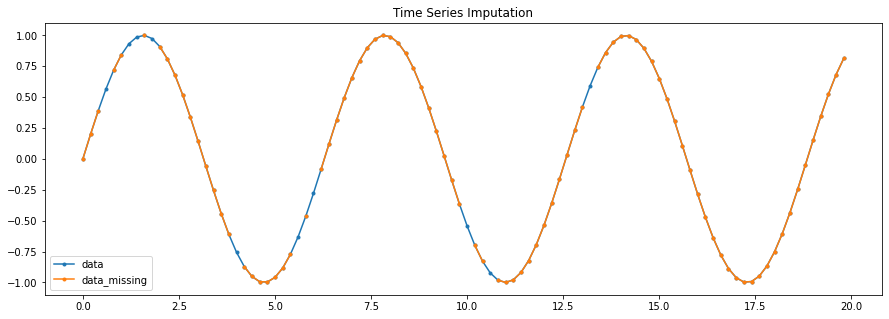

In [48]:
import matplotlib.pylab as plt
ts_data.plot(style=".-",
             figsize=(15, 5),
             title='Time Series Imputation')
plt.show()

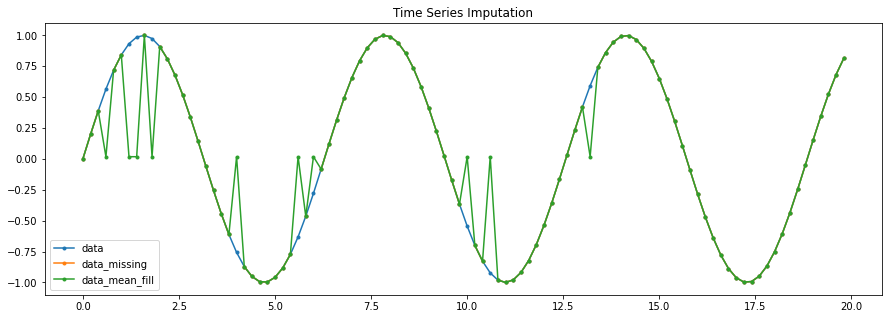

In [49]:
ts_data = pd.DataFrame(index=[x / 5 for x in range(100)])
ts_data["data"] = np.sin(ts_data.index)
ts_data["data_missing"] = ts_data["data"] \
    .sample(frac=0.9, random_state=529)
#ts_data["data_ffill"] = ts_data["data_missing"].ffill()
ts_data["data_mean_fill"] = ts_data["data_missing"].fillna(
    ts_data["data_missing"].mean()
)
ts_data.plot(style=".-",
             figsize=(15, 5),
             title='Time Series Imputation')
plt.show()

This is a great example why using fillna(0) is not a good idea. In this case ffill and bfill are useful in time series data. we need to make data is sorted correctly and then use 

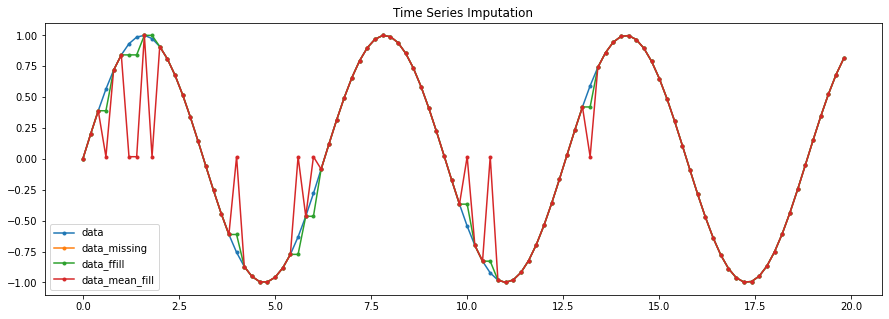

In [50]:
ts_data = pd.DataFrame(index=[x / 5 for x in range(100)])
ts_data["data"] = np.sin(ts_data.index)
ts_data["data_missing"] = ts_data["data"] \
    .sample(frac=0.9, random_state=529)
ts_data["data_ffill"] = ts_data["data_missing"].ffill()
ts_data["data_mean_fill"] = ts_data["data_missing"].fillna(
    ts_data["data_missing"].mean()
)
ts_data.plot(style=".-",
             figsize=(15, 5),
             title='Time Series Imputation')
plt.show()

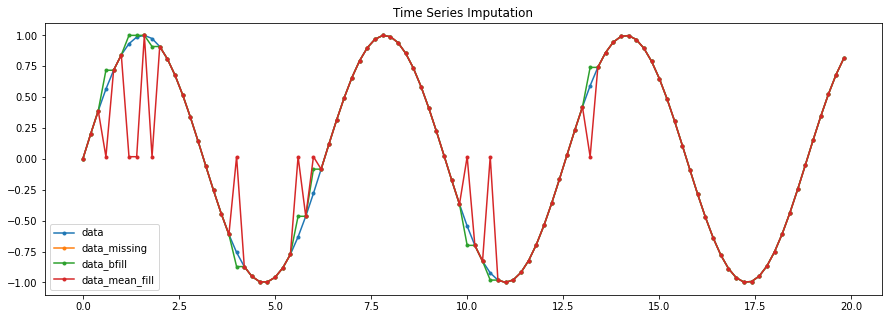

In [51]:
ts_data = pd.DataFrame(index=[x / 5 for x in range(100)])
ts_data["data"] = np.sin(ts_data.index)
ts_data["data_missing"] = ts_data["data"] \
    .sample(frac=0.9, random_state=529)
ts_data["data_bfill"] = ts_data["data_missing"].bfill()
ts_data["data_mean_fill"] = ts_data["data_missing"].fillna(
    ts_data["data_missing"].mean()
)
ts_data.plot(style=".-",
             figsize=(15, 5),
             title='Time Series Imputation')
plt.show()

### GroupBy Fill
- use the average value grouped by a different feature
- As an example we will use the audio_mode feature

In [52]:
tt.groupby("audio_mode")["song_duration_ms"].mean()

audio_mode
0    193860.636998
1    191649.429611
Name: song_duration_ms, dtype: float64

In [53]:
sd_mean_map = tt.groupby("audio_mode")["song_duration_ms"] \
    .mean().to_dict()
sd_mean_map

{0: 193860.63699819762, 1: 191649.42961114578}

In [54]:
sd_mean_series = tt['audio_mode'].map(sd_mean_map)

In [55]:
tt["song_duration_ms_mean_audio_mode"] = \
    tt["song_duration_ms"].fillna(sd_mean_series)

In [56]:
tt.query('song_duration_ms_missing == True') \
    [['audio_mode','song_duration_ms_mean_audio_mode']].head(5)

,audio_mode,song_duration_ms_mean_audio_mode
1,1,191649.429611
13,0,193860.636998
14,0,193860.636998
15,0,193860.636998
28,0,193860.636998


### Level 3: Sklearn Imputation

- SimpleImputer: Similar to pandas fillna
- IterativeImputer
- KNNImputer

Using Sklearn is good because it provides a fit and transform method. This allow  us to fit on the training data and transform on the train validation.

In real world situation we would want to fit and transform within cross validation loop to ensure no data leakage.

**Protip:** in kaggle competitions we sometimes know all of the features for the test set. So it may be advantageous to fit on all the data. This doesn't work for "code" competitions because we can't see the test data before out model predicts.


### SimpleImputer
- Impute with mean, median or just a single value
- add_indicator will add the indicator column

In [57]:
from sklearn.impute import SimpleImputer
imptr = SimpleImputer(strategy="mean", add_indicator=False)

In [58]:
df_train['song_duration_ms'].mean()


193165.84757235576

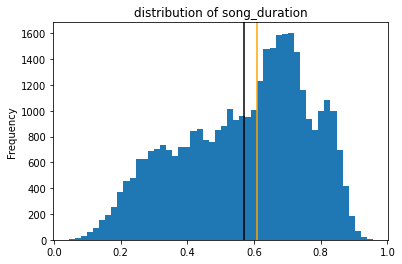

In [59]:
ax = df_train['danceability'] \
    .plot(kind='hist', bins=50,
          title='distribution of song_duration')
ax.axvline(df_train['danceability'].mean(),
           color='black')
ax.axvline(df_train['danceability'].median(),
           color='orange')

In [60]:
# Fit / Transform on train, transform only on val/test
tr_imp = imptr.fit_transform(df_train[FEATURES])
test_imp = imptr.transform(df_test[FEATURES])

In [61]:
# For kaggle competition we can kind of cheat by fitting on all data
tt_impute = imptr.fit_transform(tt[FEATURES])
tt_simple_impute = pd.DataFrame(tt_impute, columns=FEATURES)
tt_simple_impute.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.0,0.198086,-5.619088,0.0,0.082570,158.386236,4.0,0.734642
1,193150.809021,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1.0,0.127358,102.752988,3.0,0.711531
2,193213.000000,0.277183,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0.0,0.052282,178.685791,3.0,0.425536
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0.0,0.035618,128.715630,3.0,0.453597
4,165969.000000,0.493017,0.570724,0.740982,0.002033,10.0,0.094891,-2.684095,0.0,0.050746,121.928157,4.0,0.741311


### Iterative Imputer
Multivariate imputer that estimates each feature from all the others

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. 

Uses by default the BayesianRidge model to impute

**Protip :** We want to fit and predict on all columns! This is because the model is using all features to help fill the missing values.

In [62]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

it_imputer = IterativeImputer(max_iter=10)
train_iterimp = it_imputer.fit_transform(df_train[FEATURES])
test_iterimp = it_imputer.transform(df_test[FEATURES])
tt_iterimp = it_imputer.fit_transform(tt[FEATURES])

# Create train test imputed dataframe
tt_iter_imp_df = pd.DataFrame(tt_iterimp, columns=FEATURES)

In [63]:
# Save this off to use later
tt_iter_imp_df.to_parquet("tt_iterative_imp.parquet")

In [64]:
tt_iter_imp_df.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,212990.00000,0.642286,0.856520,0.707073,0.002001,10.0,0.214267,-5.619088,0.0,0.082570,158.386236,4.0,0.734642
1,196949.40443,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1.0,0.127358,102.752988,3.0,0.711531
2,193213.00000,0.161850,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0.0,0.052282,178.685791,3.0,0.425536
3,249893.00000,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0.0,0.035618,128.715630,3.0,0.453597
4,165969.00000,0.493017,0.641740,0.740982,0.002033,10.0,0.094891,-2.684095,0.0,0.050746,121.928157,4.0,0.741311


### KNN Imputer
Imputation for completing missing values using k-Nearest Neighbors.

In [65]:
from sklearn.impute import KNNImputer

knn_imptr = KNNImputer(n_neighbors=1)
train_knnimp = knn_imptr.fit_transform(df_train[FEATURES])
test_knnimp = knn_imptr.transform(df_test[FEATURES])
tt_knnimp = knn_imptr.fit_transform(tt[FEATURES])
tt_imp = pd.DataFrame(tt_knnimp, columns=FEATURES)

# Create KNN Train/Test imputed dataframe
knn_imp_df = pd.DataFrame(tt_imp, columns=FEATURES)

In [66]:
# Save this off to use later
knn_imp_df.to_parquet("tt_knn_imp.parquet")

### Level 4: LightGBM Imputer!!
https://github.com/analokmaus/kuma_utils/blob/master/preprocessing/imputer.py

In [67]:
# !rm -r kuma_utils
!git clone https://github.com/analokmaus/kuma_utils.git

Cloning into 'kuma_utils'...
remote: Enumerating objects: 881, done.
remote: Counting objects: 100% (597/597), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 881 (delta 371), reused 382 (delta 166), pack-reused 284
Receiving objects: 100% (881/881), 692.46 KiB | 982.00 KiB/s, done.
Resolving deltas: 100% (558/558), done.


In [68]:
import sys
sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

lgbm_imtr = LGBMImputer(n_iter=100, verbose=True)

train_lgbmimp = lgbm_imtr.fit_transform(df_train[FEATURES])
test_lgbmimp = lgbm_imtr.transform(df_test[FEATURES])
tt_lgbmimp = lgbm_imtr.fit_transform(tt[FEATURES])
tt_imp = pd.DataFrame(tt_lgbmimp, columns=FEATURES)

# Create LGBM Train/Test imputed dataframe
lgbm_imp_df = pd.DataFrame(tt_imp, columns=FEATURES)

song_duration_ms:	regression...iter100/100
acousticness:	regression...iter100/100
danceability:	regression...iter1/100
energy:	regression...iter100/100
instrumentalness:	regression...iter100/100
key:	regression...iter100/100
liveness:	regression...iter100/100
loudness:	regression...iter100/100
song_duration_ms:	regression...iter100/100
acousticness:	regression...iter100/100
danceability:	regression...iter1/100
energy:	regression...iter100/100
instrumentalness:	regression...iter100/100
key:	regression...iter100/100
liveness:	regression...iter100/100
loudness:	regression...iter100/100


In [69]:
tt_lgbm_imp = pd.concat([tt[["isTrain",
                             "song_popularity"]],
                         tt_lgbmimp], axis=1)

In [70]:
tt_lgbm_imp.to_parquet("tt_lgbm_imp.parquet")

#### Check The Imputation Distribution

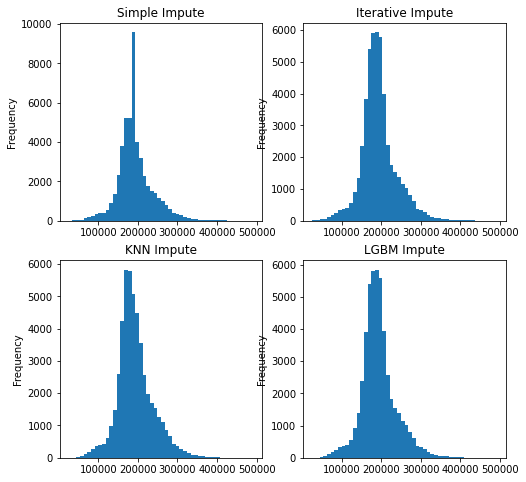

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

tt_simple_impute['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[0],
          title='Simple Impute')

tt_iter_imp_df['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          title='Iterative Impute')

knn_imp_df['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          title='KNN Impute')

tt_lgbm_imp['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[3],
          title='LGBM Impute')
plt.show()


Which Method is Best?
Try and check on cross validation!

In [72]:
train_test = pd.concat([tt_simple_impute, tt_missing_tag_df], axis =1)
train_test.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,...,time_signature,audio_valence,song_duration_ms_missing,acousticness_missing,danceability_missing,energy_missing,instrumentalness_missing,key_missing,liveness_missing,loudness_missing
0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.0,0.198086,-5.619088,0.0,0.082570,...,4.0,0.734642,False,False,False,False,False,False,True,False
1,193150.809021,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1.0,0.127358,...,3.0,0.711531,True,False,False,False,False,False,False,False
2,193213.000000,0.277183,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0.0,0.052282,...,3.0,0.425536,False,True,False,False,False,False,False,False
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0.0,0.035618,...,3.0,0.453597,False,False,False,False,False,False,False,False
4,165969.000000,0.493017,0.570724,0.740982,0.002033,10.0,0.094891,-2.684095,0.0,0.050746,...,4.0,0.741311,False,False,True,False,False,False,False,False


In [73]:
train = train_test.iloc[:40000]
test = train_test.iloc[40000:]

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import mode


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

from matplotlib import ticker
import time
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')


RANDOM_STATE = 12 
FOLDS = 5

catb_params = {
    "objective": "Logloss",
}

TARGET = 'song_popularity'
catb_predictions = 0
catb_scores = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train, df_train[TARGET])):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train , y_valid = df_train[TARGET].iloc[train_idx] , df_train[TARGET].iloc[valid_idx]
    model = CatBoostClassifier(**catb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  preds_valid)
    catb_scores.append(auc)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
    test_preds = model.predict_proba(test)[:, 1]
    catb_predictions += test_preds/FOLDS
    
print("Mean AUC :", np.mean(catb_scores))

========== Fold=1 ==========
Fold=1, AUC score: 0.56, Run Time: 7.91s
========== Fold=2 ==========
Fold=2, AUC score: 0.58, Run Time: 7.26s
========== Fold=3 ==========
Fold=3, AUC score: 0.57, Run Time: 7.25s
========== Fold=4 ==========
Fold=4, AUC score: 0.56, Run Time: 7.32s
========== Fold=5 ==========
Fold=5, AUC score: 0.56, Run Time: 7.31s
Mean AUC : 0.5652353244031948


In [75]:
submission = pd.read_csv('../input/song-popularity-prediction/sample_submission.csv')
catb_submission = submission.copy()
catb_submission['song_popularity'] = catb_predictions
catb_submission.to_csv("catb-subs.csv",index=False)
catb_submission.head()

,id,song_popularity
0,0,0.464582
1,1,0.471127
2,2,0.124714
3,3,0.292137
4,4,0.320574
